Library

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sqlalchemy import create_engine
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import xgboost as xgb

Mengambil data dari MySQL

In [8]:
engine = create_engine("mysql+pymysql://root:@localhost/magang")
query = """
SELECT waktu, voltage, current, power, frequency, powerfactor
FROM meter_1
"""
df = pd.read_sql(query, con=engine)
df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')
print(f"Jumlah Baris = {df.shape[0]}")
display(df.head())

Jumlah Baris = 3100


,voltage,current,power,frequency,powerfactor
waktu,,,,,
2025-01-28 07:41:46,380.78,32.03,20.58,49.98,0.97
2025-01-28 07:41:48,380.78,32.03,20.52,49.98,0.97
2025-01-28 07:41:55,380.35,31.99,20.52,49.98,0.97
2025-01-28 07:42:01,380.35,31.99,20.53,49.98,0.97
2025-01-28 07:42:04,380.49,31.97,20.53,49.99,0.97


Visualisasi data awal

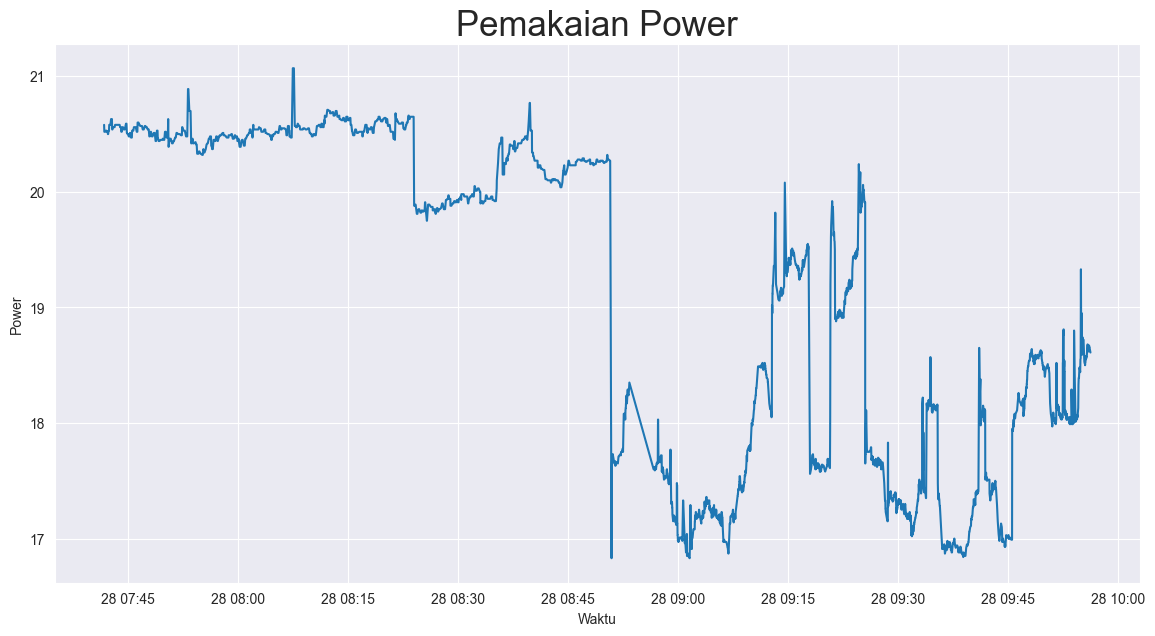

In [9]:
plt.figure(figsize=(14, 7))
sns.set_style('darkgrid')
plt.plot(df.index, df['power'])
plt.title("Pemakaian Power", fontsize=25)
plt.xlabel("Waktu")
plt.ylabel("Power")
plt.show()

Preprocessing

In [10]:
df = pd.read_sql(query, con=engine)
df['waktu'] = pd.to_datetime(df['waktu'])
df.set_index('waktu', inplace=True)
print(df.isnull().sum())
df.dropna(inplace=True)
X = df.drop(columns='power')  
y = df['power'] 

voltage        0
current        0
power          0
frequency      0
powerfactor    0
dtype: int64


Split data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

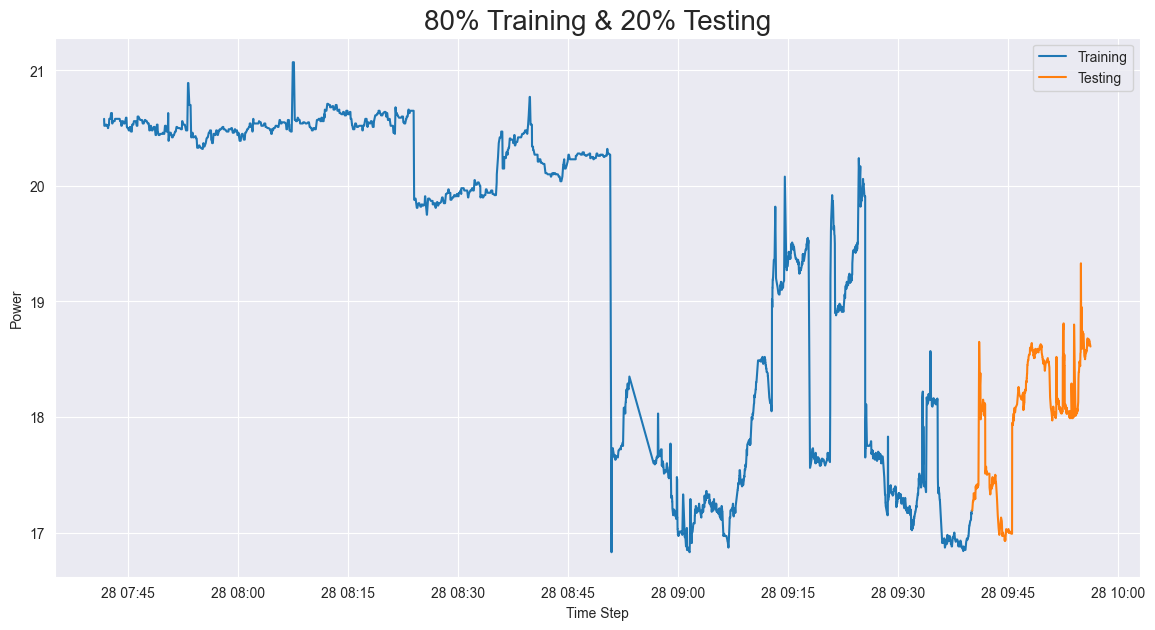

In [6]:
def split_data(data, train_size=0.8):
    train_len = int(len(data) * train_size)
    train = data[:train_len]
    test = data[train_len:]
    return train, test
train, test = split_data(df['power'], 0.8)

plt.figure(figsize=(14, 7))
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
plt.title('80% Training & 20% Testing', fontsize=20)
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

Tampilan 3 fitur

In [14]:

models = {
    "ExtraTrees": ExtraTreesRegressor(n_estimators=1000, random_state=100),
    "XGBoost": xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=100, objective='reg:squarederror'),
    "RandomForest": RandomForestRegressor(n_estimators=1000, random_state=100)
}

# Dictionary untuk menyimpan hasil evaluasi
results = {}
predictions = {}  # <--- tambahkan ini untuk simpan y_pred

# Training dan evaluasi
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2
    }

# Cetak hasil evaluasi semua model
for name, metrics in results.items():
    print(f"\n📊 Evaluasi Model {name}:")
    print(f"- Mean Squared Error (MSE)      : {metrics['MSE']:.4f} kW²")
    print(f"- Root Mean Squared Error (RMSE): {metrics['RMSE']:.4f} kW")
    print(f"- Mean Absolute Error (MAE)     : {metrics['MAE']:.4f} kW")
    print(f"- Mean Absolute Percentage Error (MAPE): {metrics['MAPE']:.2f}%")
    print(f"- R-squared (R² Score)          : {metrics['R2']:.4f}")



📊 Evaluasi Model ExtraTrees:
- Mean Squared Error (MSE)      : 0.0162 kW²
- Root Mean Squared Error (RMSE): 0.1273 kW
- Mean Absolute Error (MAE)     : 0.0520 kW
- Mean Absolute Percentage Error (MAPE): 0.28%
- R-squared (R² Score)          : 0.9900

📊 Evaluasi Model XGBoost:
- Mean Squared Error (MSE)      : 0.0164 kW²
- Root Mean Squared Error (RMSE): 0.1279 kW
- Mean Absolute Error (MAE)     : 0.0520 kW
- Mean Absolute Percentage Error (MAPE): 0.28%
- R-squared (R² Score)          : 0.9899

📊 Evaluasi Model RandomForest:
- Mean Squared Error (MSE)      : 0.0140 kW²
- Root Mean Squared Error (RMSE): 0.1182 kW
- Mean Absolute Error (MAE)     : 0.0484 kW
- Mean Absolute Percentage Error (MAPE): 0.26%
- R-squared (R² Score)          : 0.9914


Visualisasi ketiganya

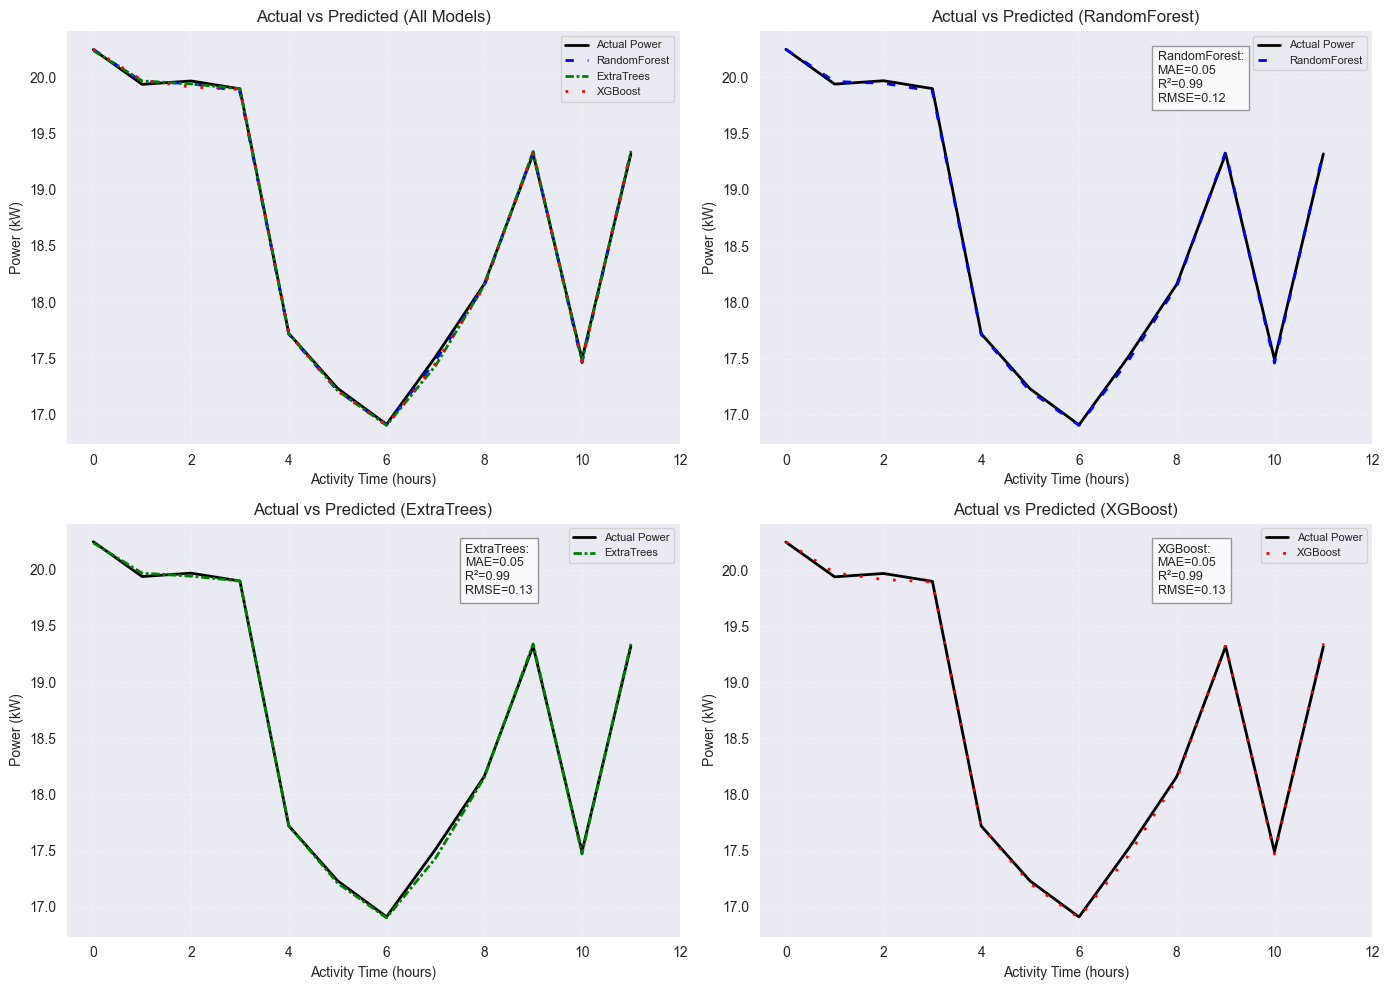

In [ ]:
# ====================================
# Plot 4 grafik dalam 1 figure (2x2 layout)
# ====================================
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# -----------------------------
# 1. Gabungan semua model
# -----------------------------
ax = axes[0,0]
ax.plot(x_axis, y_actual_sample, 'k-', linewidth=2, label="Actual Power")
for key in ["RandomForest", "ExtraTrees", "XGBoost"]:
    ax.plot(x_axis, predictions[key][indices],
            color=colors[key], linestyle=linestyles[key], linewidth=2, label=key)

ax.set_title("Actual vs Predicted (All Models)")
ax.set_xlabel("Activity Time (hours)")
ax.set_ylabel("Power (kW)")
ax.set_xticks(np.arange(0, n_show + 1, 2))
ax.legend(fontsize=8)
ax.grid(True, linestyle="--", alpha=0.3)

# -----------------------------
# 2. RandomForest
# -----------------------------
ax = axes[0,1]
key = "RandomForest"
ax.plot(x_axis, y_actual_sample, 'k-', linewidth=2, label="Actual Power")
ax.plot(x_axis, predictions[key][indices],
        color=colors[key], linestyle=linestyles[key], linewidth=2, label=key)
ax.set_title(f"Actual vs Predicted ({key})")
ax.set_xlabel("Activity Time (hours)")
ax.set_ylabel("Power (kW)")
ax.set_xticks(np.arange(0, n_show + 1, 2))
ax.legend(fontsize=8)
ax.grid(True, linestyle="--", alpha=0.3)
textstr = (f"{key}:\nMAE={results[key]['MAE']:.2f}\n"
           f"R²={results[key]['R2']:.2f}\n"
           f"RMSE={results[key]['RMSE']:.2f}")
ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=9,
        va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

# -----------------------------
# 3. ExtraTrees
# -----------------------------
ax = axes[1,0]
key = "ExtraTrees"
ax.plot(x_axis, y_actual_sample, 'k-', linewidth=2, label="Actual Power")
ax.plot(x_axis, predictions[key][indices],
        color=colors[key], linestyle=linestyles[key], linewidth=2, label=key)
ax.set_title(f"Actual vs Predicted ({key})")
ax.set_xlabel("Activity Time (hours)")
ax.set_ylabel("Power (kW)")
ax.set_xticks(np.arange(0, n_show + 1, 2))
ax.legend(fontsize=8)
ax.grid(True, linestyle="--", alpha=0.3)
textstr = (f"{key}:\nMAE={results[key]['MAE']:.2f}\n"
           f"R²={results[key]['R2']:.2f}\n"
           f"RMSE={results[key]['RMSE']:.2f}")
ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=9,
        va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

# -----------------------------
# 4. XGBoost
# -----------------------------
ax = axes[1,1]
key = "XGBoost"
ax.plot(x_axis, y_actual_sample, 'k-', linewidth=2, label="Actual Power")
ax.plot(x_axis, predictions[key][indices],
        color=colors[key], linestyle=linestyles[key], linewidth=2, label=key)
ax.set_title(f"Actual vs Predicted ({key})")
ax.set_xlabel("Activity Time (hours)")
ax.set_ylabel("Power (kW)")
ax.set_xticks(np.arange(0, n_show + 1, 2))
ax.legend(fontsize=8)
ax.grid(True, linestyle="--", alpha=0.3)
textstr = (f"{key}:\nMAE={results[key]['MAE']:.2f}\n"
           f"R²={results[key]['R2']:.2f}\n"
           f"RMSE={results[key]['RMSE']:.2f}")
ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=9,
        va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.tight_layout()
plt.show()


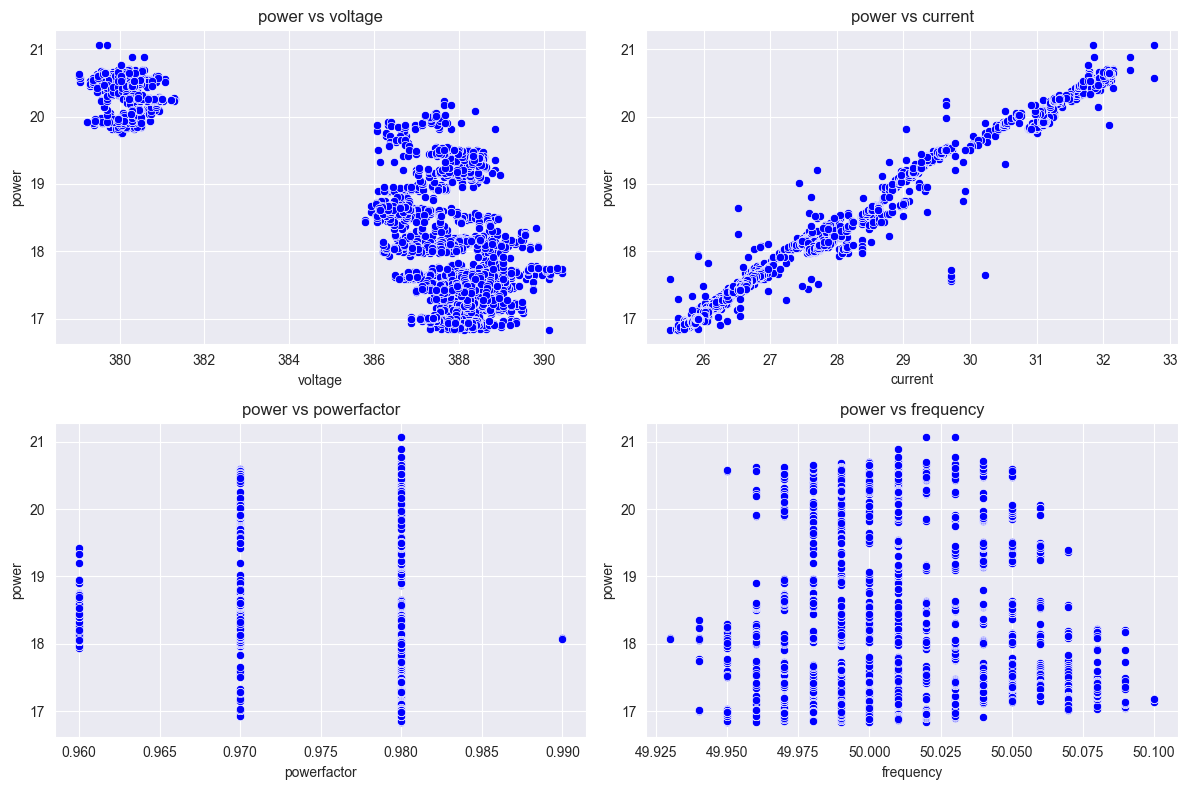

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['voltage', 'current', 'powerfactor', 'frequency']  # sesuaikan dengan df.columns
target = 'power'

plt.figure(figsize=(12, 8))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=df, x=feature, y=target, color="blue")
    plt.title(f"{target} vs {feature}")

plt.tight_layout()
plt.show()


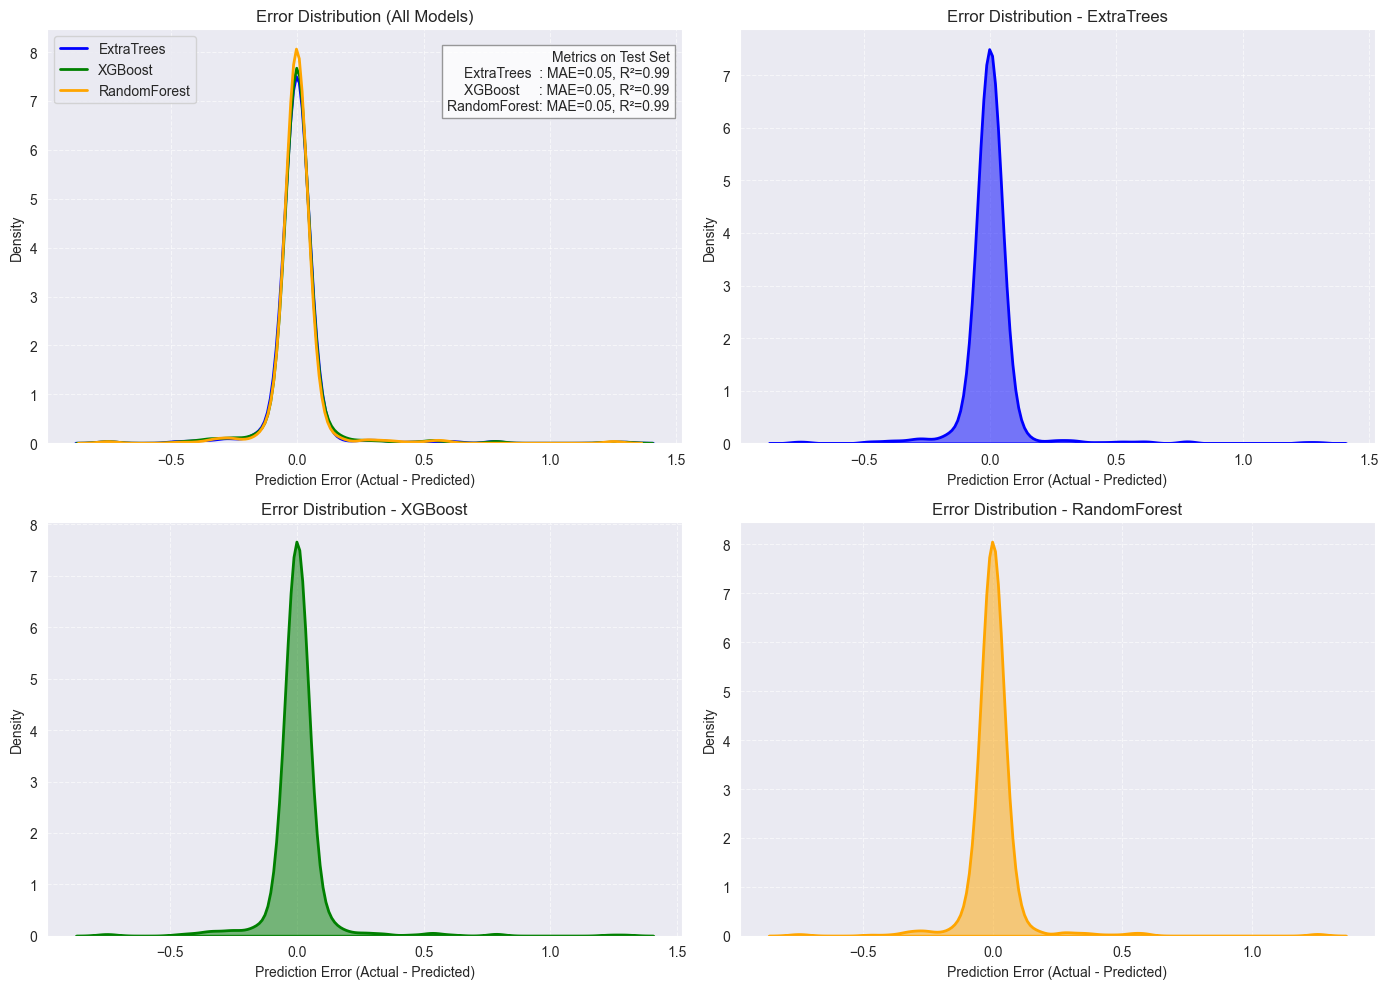

In [ ]:
# ======================
# 1. Definisi model
# ======================
models = {
    "ExtraTrees": ExtraTreesRegressor(n_estimators=1000, random_state=100),
    "XGBoost": xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6,
                                random_state=100, objective='reg:squarederror'),
    "RandomForest": RandomForestRegressor(n_estimators=1000, random_state=100)
}

results = {}
predictions = {}

# ======================
# 2. Training & evaluasi
# ======================
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}

# ======================
# 3. Plot distribusi error
# ======================
y_test_arr = y_test.values if hasattr(y_test, "values") else np.asarray(y_test)
errors = {key: y_test_arr - pred for key, pred in predictions.items()}
colors = {"RandomForest": "orange", "ExtraTrees": "blue", "XGBoost": "green"}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# --- Plot 1: Semua model digabung ---
for key in errors:
    sns.kdeplot(errors[key], fill=False, label=key, color=colors[key], linewidth=2, ax=axes[0])
axes[0].set_title("Error Distribution (All Models)")
axes[0].set_xlabel("Prediction Error (Actual - Predicted)")
axes[0].set_ylabel("Density")
axes[0].legend(loc="upper left")
axes[0].grid(True, linestyle="--", alpha=0.6)

# --- Plot 2-4: Per model ---
for i, key in enumerate(errors.keys(), start=1):
    sns.kdeplot(errors[key], fill=True, color=colors[key], alpha=0.5, linewidth=2, ax=axes[i])
    axes[i].set_title(f"Error Distribution - {key}")
    axes[i].set_xlabel("Prediction Error (Actual - Predicted)")
    axes[i].set_ylabel("Density")
    axes[i].grid(True, linestyle="--", alpha=0.6)

# Tambah teks metrik di pojok kanan atas plot gabungan
lines = ["Metrics on Test Set"]
for key in results:
    lines.append(f"{key:<12}: MAE={results[key]['MAE']:.2f}, R²={results[key]['R2']:.2f}")
textstr = "\n".join(lines)

axes[0].text(
    0.98, 0.95, textstr,
    transform=axes[0].transAxes,
    fontsize=10, va="top", ha="right",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
)

plt.tight_layout()
plt.show()